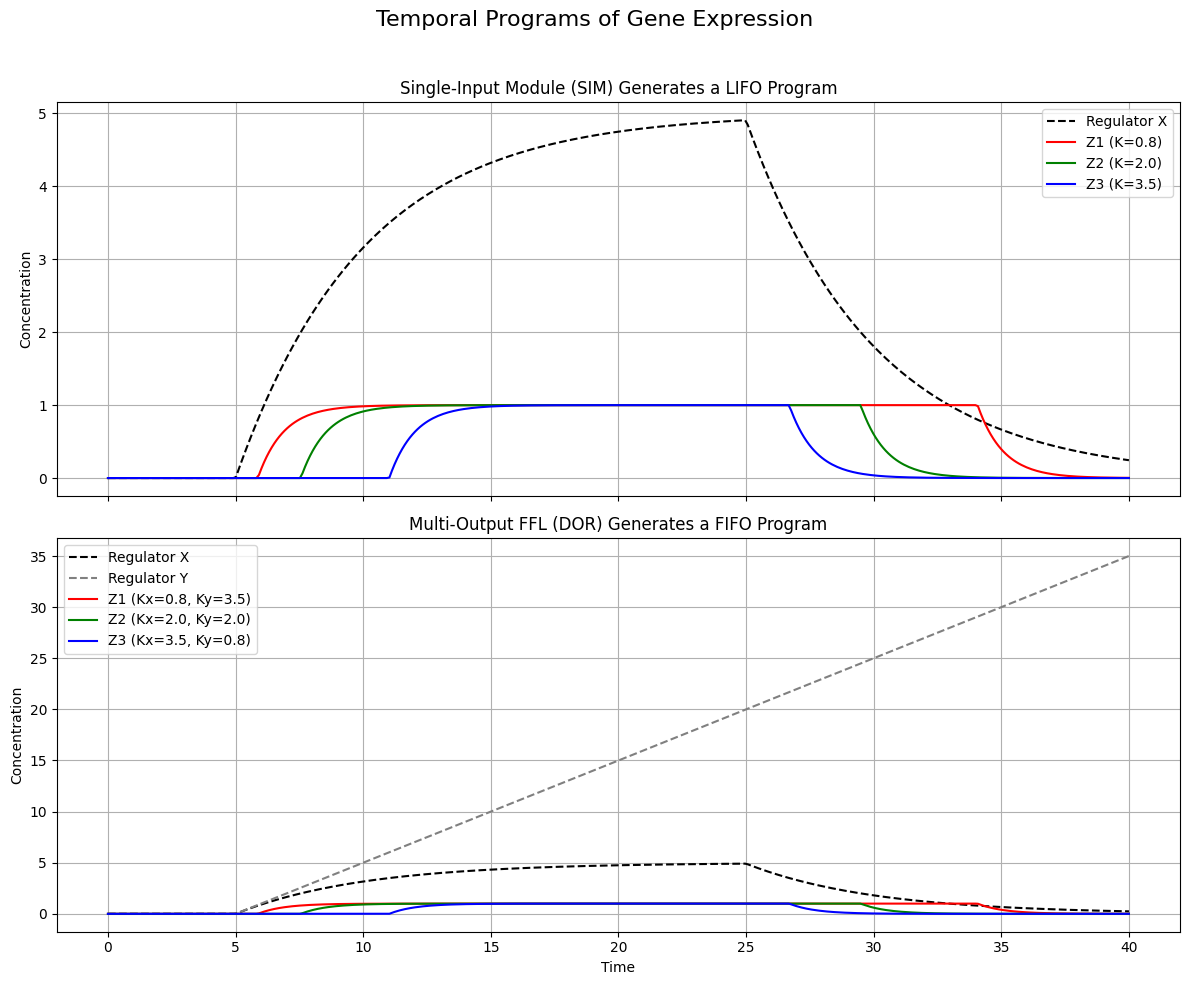

In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- Part 1: Define a model for a master regulator X ---
# The level of X will rise and then fall, driving the programs.
def regulator_X(t, t_on, t_off, beta_X, alpha_X):
    """Models the concentration of regulator X over time."""
    if t < t_on:
        return 0
    elif t_on <= t < t_off:
        # Rising phase
        return (beta_X / alpha_X) * (1 - np.exp(-alpha_X * (t - t_on)))
    else: # t >= t_off
        # Falling phase
        X_at_off = (beta_X / alpha_X) * (1 - np.exp(-alpha_X * (t_off - t_on)))
        return X_at_off * np.exp(-alpha_X * (t - t_off))

# --- Part 2: Simulate the SIM (LIFO Program) ---

# Define the model for the output genes Z in a SIM
def sim_model(Z, t, X_func, K, beta, alpha):
    """dZ/dt for a single output gene in a SIM."""
    X = X_func(t)
    # Production is ON if X > K (logic approximation)
    production = beta if X > K else 0
    dZdt = production - alpha * Z
    return dZdt

# SIM Parameters
t_on, t_off = 5, 25  # X is ON from t=5 to t=25
beta_X, alpha_X = 1, 0.2
X_sim_func = lambda t: regulator_X(t, t_on, t_off, beta_X, alpha_X)

# Thresholds for Z1, Z2, Z3 (LIFO requires increasing thresholds)
K_sim = [0.8, 2.0, 3.5]
colors_sim = ['r', 'g', 'b']
labels_sim = [f'Z1 (K={K_sim[0]})', f'Z2 (K={K_sim[1]})', f'Z3 (K={K_sim[2]})']

# Simulation time and initial conditions
t_sim = np.linspace(0, 40, 400)
Z0 = 0

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Temporal Programs of Gene Expression', fontsize=16)

# Plot X concentration for the SIM
ax1.plot(t_sim, [X_sim_func(ti) for ti in t_sim], 'k--', label='Regulator X')

# Simulate and plot each Z gene for the SIM
for i in range(3):
    solution = odeint(sim_model, Z0, t_sim, args=(X_sim_func, K_sim[i], 1, 1))
    ax1.plot(t_sim, solution, color=colors_sim[i], label=labels_sim[i])

ax1.set_title('Single-Input Module (SIM) Generates a LIFO Program')
ax1.set_ylabel('Concentration')
ax1.legend()
ax1.grid(True)

# --- Part 3: Simulate the DOR (FIFO Program) ---

# We'll need a model for Y as well
def regulator_Y_in_DOR(t, X_func, beta_Y, alpha_Y):
    """Integrates the production of Y based on X's concentration."""
    y_solution = odeint(lambda y, t: beta_Y if X_func(t) > 0 else -alpha_Y*y, 0, t)
    return y_solution[-1,0] if len(y_solution) > 0 else 0

# Let's pre-calculate Y values to speed up the main simulation
Y_dor_func_map = {ti: regulator_Y_in_DOR(np.linspace(0,ti,int(ti*10)+1), X_sim_func, 1, 0.2) for ti in t_sim}
Y_dor_func = lambda t: Y_dor_func_map.get(t,0)


# Define the model for the output genes Z in a DOR with OR-logic
def dor_model(Z, t, X_func, Y_func, Kx, Ky, beta, alpha):
    """dZ/dt for a single output gene in a DOR (OR-gate)."""
    X = X_func(t)
    Y = Y_func(t)
    # Production is ON if X > Kx OR Y > Ky
    production = beta if (X > Kx or Y > Ky) else 0
    dZdt = production - alpha * Z
    return dZdt

# DOR Parameters (Anti-correlated thresholds for FIFO)
Kx_dor = [0.8, 2.0, 3.5]  # X thresholds are increasing (determines ON-order)
Ky_dor = [3.5, 2.0, 0.8]  # Y thresholds are decreasing (determines OFF-order)
colors_dor = ['r', 'g', 'b']
labels_dor = [f'Z1 (Kx={Kx_dor[0]}, Ky={Ky_dor[0]})',
              f'Z2 (Kx={Kx_dor[1]}, Ky={Ky_dor[1]})',
              f'Z3 (Kx={Kx_dor[2]}, Ky={Ky_dor[2]})']

# Plot X and Y concentrations for the DOR
ax2.plot(t_sim, [X_sim_func(ti) for ti in t_sim], 'k--', label='Regulator X')
ax2.plot(t_sim, [Y_dor_func(ti) for ti in t_sim], 'gray', linestyle='--', label='Regulator Y')

# Simulate and plot each Z gene for the DOR
for i in range(3):
    solution = odeint(dor_model, Z0, t_sim, args=(X_sim_func, Y_dor_func, Kx_dor[i], Ky_dor[i], 1, 1))
    ax2.plot(t_sim, solution, color=colors_dor[i], label=labels_dor[i])

ax2.set_title('Multi-Output FFL (DOR) Generates a FIFO Program')
ax2.set_xlabel('Time')
ax2.set_ylabel('Concentration')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()